# AI project – Zucchetti Spa dataset

## Preprocessing

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

UNKNOWN = 'unknown'
SAMPLE = 10

In [8]:
# Read in the data from the CSV file
df = pd.read_csv('coded_log.csv', sep=";",names=['userId', '1?', 'date','eventType','application','2?','ip','3?','4?','5?'])

In [9]:
# Visualize a snippet of the data frame df
df.sample(SAMPLE)

,userId,1?,date,eventType,application,2?,ip,3?,4?,5?
515401,21630,22969666,2021-04-01 11:55:29.000,1,ERM,erm3zs02,ip_1360,001,ruqnpvapib,lv3kliy5ax
483631,20333,478303947,2021-06-20 23:07:55.000,1,HRW,NaN,NaN,001,urokuemkoh,z1of95dgh6
353888,13584,806865786,2021-05-27 08:52:10.000,1,HRW,NaN,NaN,006,xkfubqfjtc,w1c1vm05u6
840798,33320,246815633,2021-04-23 09:31:44.000,1,ERM,erm3zs02,ip_566,001,ujiyhvfqdq,xrv9zcvwr0
304760,12058,680189308,2021-06-01 20:40:40.000,2,ERM,erm3zs02,ip_10953,,,ekrsjfe4wp
414341,18174,183288806,2020-09-08 15:27:36.000,3,HR1,NaN,NaN,001,ijvpfmsbfr,d72svz8w1f
20555,299,442012979,2021-04-23 16:09:54.000,1,HRW,NaN,NaN,001,wdnlrdtvgv,bbdptvzf7b
380230,15013,707863756,2021-06-14 10:42:13.000,3,HRW,NaN,NaN,001,rkspfklksj,kuac9j90rs
107885,2142,172091165,2021-05-31 06:29:11.000,1,ERM,erm3zs02,ip_1463,001,idgtaxdzaf,x8od3cy7dq
833426,33181,377861798,2021-06-21 17:35:33.000,1,ERM,erm3zs02,ip_916,001,hixjwcmhig,xhcid1ku6x


In [10]:
#remove unkown coloums
df_ = df.drop(columns=['1?','2?','3?','4?','5?'])
df_.sample(SAMPLE)

,userId,date,eventType,application,ip
110227,2182,2021-05-17 10:31:15.000,3,ERM,ip_1467
670033,27372,2021-06-04 17:35:16.000,1,ERM,ip_1360
117295,2317,2021-06-23 16:14:58.000,1,ERM,ip_1477
549900,23189,2021-05-04 17:28:24.000,1,ERM,ip_9447
841673,33325,2021-06-08 09:41:37.000,1,HR1,NaN
541007,22901,2021-05-05 17:58:49.000,3,ERM,ip_128
351640,13566,2021-05-17 08:27:41.000,1,ERM,ip_126
561990,23503,2021-05-03 11:57:24.000,1,HRW,NaN
30754,589,2021-04-30 14:17:58.000,1,ERM,ip_539
367865,13886,2021-06-21 11:46:40.000,1,HRW,NaN


In [11]:
#cleaning row data
print('number of null entries:')
df_.isnull().sum()

number of null entries:


userId              0
date                0
eventType           0
application         0
ip             339741
dtype: int64

In [12]:
# replacing not-specified ip addresses
df_['ip'].fillna(UNKNOWN,inplace=True)
df_.sample(SAMPLE)

,userId,date,eventType,application,ip
218540,4191,2021-06-14 11:49:39.000,1,ERM,ip_1360
150855,2909,2021-05-07 17:44:16.000,1,HRW,unknown
490930,20430,2021-06-01 11:47:47.000,3,ERM,ip_16814
559464,23465,2021-03-31 08:26:18.000,1,ERM,ip_15279
222188,4276,2020-11-19 11:17:59.000,1,HRW,unknown
796960,32285,2020-12-11 08:43:24.000,1,ERM,ip_42069
66611,1452,2021-05-18 13:59:51.000,1,ERM,ip_1865
4708,1,2021-06-16 18:31:51.000,1,HRW,unknown
612966,25293,2021-04-01 11:16:07.000,1,HRW,unknown
207297,3959,2021-05-12 16:37:20.000,1,HR1,unknown


### Data cleaning

In [13]:
df_['date'] = pd.to_datetime(df_['date'], format="%Y-%m-%d %H:%M:%S.%f")

# sorting by date and userId
df_.sort_values(by=["userId", "date"],ascending=(True, True),inplace=True)

# check data consistency: delete rows containing non-valid event code
df_ = df_[(df_.eventType >= 1) & (df_.eventType <= 3)]

# check data rendundancy
duplicates = df_.duplicated().sum()
if(duplicates > 0):
    print(f'Duplicates number {duplicates} on {len(df_.index)}')
    df_.drop_duplicates(inplace = True)
    print(f'New size:{len(df_.index)}')

Duplicates number 3432 on 849552
New size:846120


In [14]:
# counting unique values
userIdNumber = len(pd.unique(df_['userId']))
print(f'Within the dataframe there are {userIdNumber} users')

Within the dataframe there are 18080 users


In [15]:
print(f"{df_.groupby('eventType').eventType.count()}")

eventType
1    628356
2     92058
3    125706
Name: eventType, dtype: int64


### Utility functions

#### Constants

In [16]:
# working hours boundaries
START_WORKING = 8
END_WORKING = 19
# time boundaries for series construction
AT_LEAST_ONE_DAY = 24 * 3600 * 1000 # 24 h
MAX_DELAY_ERRORS = 5 * 60 * 1000 # 5min
MAX_DELAY_SUCCESS = 5 * 60 * 1000 # 5min
# attempts boundaries
MAX_ATTEMPTS = 3
MAX_TIME_BOT = 5000 # estimate both maximum time. We consider mocking user typing
RESIDUAL_TIME = MAX_DELAY_ERRORS - MAX_TIME_BOT

# FAILED ATTEMPTS WEIGHTS
# lower than MAX_ATTEMPTS 
F_ATT_LOW_MAX_WS = 0.1 # with final sucessful attempt
F_ATT_LOW_MAX_NS = 0.5 # no final sucessful attempt
# higher than MAX_ATTEMPTS 
F_ATT_HIGH_MAX_WS = 0.7 # with final sucessful attempt
F_ATT_HIGH_MAX_NS = 0.95 # no final sucessful attempt
# higher than MAX_ATTEMPTS and lower then two times MAX_ATTEMPTS
F_ATT_HIGH_MAX_LOW_2MAX_NS = 0.7 # no final sucessful attempt

# AVERAGE TIME WEIGHTS
LOWER_THAN_BOT_TIME = 0.99 # average lower than estimate bot time
BTW_BOT_AND_DIFF = 0.85 # average higher than estimate bot time and lower than RESIDUAL_TIME
HIGHER_THAN_BOT_TIME = 0.75 # higher than estimate bot time and than RESIDUAL_TIME

# events type
FAILED_LOGIN = 2
SUCCESSFUL_LOGIN = 1
LOGOUT = 3

# weights for timetable
WORKINGTIME_WORKINGDAY = 0.25
NOT_WORKINGTIME_WEEKDAY = 0.35
WORKINGTIME_NOT_WORKINGDAY = 0.45
NOT_WORKINGTIME_NOT_WEEKDAY = 0.55

#### Weigthing function

In [17]:
"""
    @brief: compute the suspicious value of a series
    @param: series
    @return: suspicious value
"""
def suspicious(series):
    """
    series[0] = "userId"
    series[1] = "avgTime"
    series[2] = "failedAttempts"
    series[3] = "hasSuccess"
    series[4] = "application"
    series[5] = "workingTime"
    series[6] = "day"
    series[7] = "ipAmount" or "userAmount"
    series[8] = "suspicious"
    """
    
    # series weights
    timeW = timeWeight(series[6], series[5])       # one ip/user case
    amountW = 1 - (1/(series[7]) if series[7] > 1 else 0.6)  
    avgtimeW = avgTimeWight(series[1])
    attemptsW = failedAttemptsWeight(series[3],series[2])
    
    return graham([timeW,amountW,avgtimeW,attemptsW])

# graham formula to avoid underflow when multiplying weights
def graham(weights:list):
    mu = 0
    for w in weights:
        mu += np.log(1 - w) - np.log(w)
    return 1/(1+np.e**mu)

# return weight timetable
def timeWeight(day, isWorkingTime):
    weekDay = day in range(1,6)
    if isWorkingTime and weekDay:
        w = WORKINGTIME_WORKINGDAY
    elif not isWorkingTime and weekDay:
        w = NOT_WORKINGTIME_WEEKDAY
    elif isWorkingTime and not weekDay:
        w = WORKINGTIME_NOT_WORKINGDAY
    elif not isWorkingTime and not weekDay:
        w = NOT_WORKINGTIME_NOT_WEEKDAY
    return w


def avgTimeWight(avgTime):
    w = 0
    if avgTime <= MAX_TIME_BOT:
        w = LOWER_THAN_BOT_TIME 
    elif MAX_TIME_BOT < avgTime <= RESIDUAL_TIME:
        w = BTW_BOT_AND_DIFF
    else: 
        w = HIGHER_THAN_BOT_TIME
    return w

def failedAttemptsWeight(hasSuccess,failedAttempts):
    w_attempts = 0
    if hasSuccess:
        if failedAttempts <= MAX_ATTEMPTS:
            w_attempts = F_ATT_LOW_MAX_WS
        else:
            w_attempts = F_ATT_HIGH_MAX_WS
    else:
        if failedAttempts <= MAX_ATTEMPTS:
            w_attempts = F_ATT_LOW_MAX_NS
        elif failedAttempts <= 2 * MAX_ATTEMPTS:
            w_attempts = F_ATT_HIGH_MAX_LOW_2MAX_NS
        else:
            w_attempts = F_ATT_HIGH_MAX_NS
    return w_attempts
    
    

## Dataframe login construction

#### Lambda functions

In [18]:
# deterimine if the log was during working hours
isWorkingTime = lambda x: 1 if (x.isoweekday() in range(1,6) and x.to_pydatetime().hour >= START_WORKING and x.to_pydatetime().hour <= END_WORKING) else 0

# toDay: convert a stirng representing a date into a number 
#    1 --> Monday
#    2 --> Tuesday
#    ...
#    7 --> Sunday
toDay = lambda x: x.isoweekday() 

In [19]:
# setting up login dataframe
df_logins = pd.DataFrame(columns=['userId', 'date', 'day', 'workingTime', 'eventType', 'application',"ip"])
df_logins['userId'] = df_['userId']
df_logins['date'] = df_["date"]
df_logins['day'] = df_logins['date'].apply(toDay)
df_logins['workingTime'] = df_logins['date'].apply(isWorkingTime)
df_logins['eventType'] = df_['eventType']
df_logins['application'] = df_['application']
df_logins['ip'] = df_['ip']
df_logins.sample(SAMPLE)

,userId,date,day,workingTime,eventType,application,ip
434775,18801,2021-02-18 16:37:10,4,1,1,HRW,unknown
214188,4087,2021-05-04 12:46:00,2,1,1,HRW,unknown
439229,19021,2021-06-01 09:31:12,2,1,1,ERM,ip_12239
728750,29229,2021-05-21 11:53:34,5,1,3,TM3,unknown
15958,195,2021-06-08 12:45:52,2,1,1,HR1,unknown
5856,1,2021-05-23 23:46:40,7,0,1,HRW,unknown
339402,13352,2021-05-12 09:26:13,3,1,1,ERM,ip_126
75733,1612,2021-05-24 16:01:01,1,1,3,ERM,ip_1467
817846,32908,2021-01-14 23:08:34,4,0,2,ERM,ip_43144
362442,13673,2021-05-05 08:01:12,3,1,3,ERM,ip_5477


####  Login dataframe plotting

Every log between Friday and Sunday occurred outside working time 

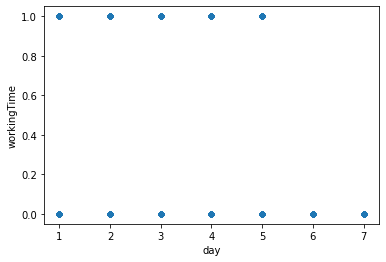

In [20]:
df_logins.plot(x = 'day', y = 'workingTime', kind = 'scatter')
plt.show()

Whatever kind of event is happened in both working time and non-working time

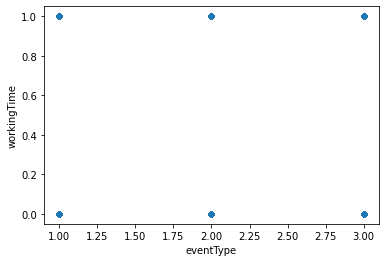

In [21]:
df_logins.plot(x = 'eventType', y = 'workingTime', kind = 'scatter')
plt.show()

Failed logins attempts occurred only for application ERM, HRW and TM3 

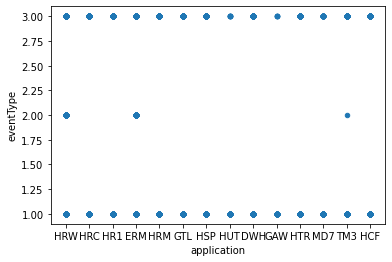

In [22]:
df_logins.plot(x = 'application', y = 'eventType', kind = 'scatter')
plt.show()

In [23]:
# remove attempts regarding applications with no errors associated
df_logins.drop(df_logins[df_logins["application"].isin(["ERM","HRW","TM3"]) == False].index ,inplace=True)
np.unique(df_logins["application"])

array(['ERM', 'HRW', 'TM3'], dtype=object)

### Series dataframe construction

In [24]:
# group by the userId
df_groupbyUserId = df_logins.groupby('userId')

In [25]:
# retrieving users id
users_id = []
for key, value in df_groupbyUserId:
    users_id.append(key)

# contains userId
userList = []

# searching for userId having 0 or 1 login errors
for i in users_id:
    user_group = df_groupbyUserId.get_group(i)
    ctr = user_group[user_group["eventType"] == FAILED_LOGIN].count()
    if ctr["eventType"] <= 1:
        userList.append(i)

In [26]:
# removing from login dataframe all the users found
df_logins.drop(df_logins[df_logins["userId"].isin(userList)].index,inplace=True)

In [27]:
df_groupbyUserId = df_logins.groupby('userId')

In [28]:
# list of remaining userId 
users_id = [user for user in users_id if (user not in userList)]

userList.clear()

# getting all users having at least two login errors
for i in users_id:
    user_group = df_groupbyUserId.get_group(i)
    rowsNumber = len(user_group.index)
    j = 0
    while j < rowsNumber - 1:
        # if user has a login error
        if user_group.iloc[j]["eventType"] == FAILED_LOGIN:
            k = j+1
            # search for another one
            while k < rowsNumber and user_group.iloc[k]["eventType"] != FAILED_LOGIN:
                k += 1
            # if found 
            if k == 1 or k != rowsNumber: 
                userList.append(i) # save user id 
                break
            j = k
        else:
            j += 1

In [29]:
# removing from login dataframe all users except the ones found
df_logins.drop(df_logins[df_logins["userId"].isin(userList) == False].index,inplace=True)

In [30]:
df_groupbyUserId = df_logins.groupby('userId')

In [31]:
# list of remaining userId
users_id = [user for user in users_id if (user in userList)]

userList = []

# selecting all users having at least 2 login errors within 24h
for i in users_id:
    user_group = df_groupbyUserId.get_group(i)
    rowsNumber = len(user_group.index)
    j = 0
    while j < rowsNumber - 1:
        # if user has a login error
        if user_group.iloc[j]["eventType"] == FAILED_LOGIN:
            k = j+1
            # search for another one
            while k < rowsNumber and user_group.iloc[k]["eventType"] != FAILED_LOGIN:
                k += 1
            # if found
            if k == 1 or k != rowsNumber:
                # compute delay between the two attempts
                delta = int((user_group.iloc[k]["date"] - user_group.iloc[j]["date"]).total_seconds()) * 1000
                # check if it is within 24h
                if delta < AT_LEAST_ONE_DAY:
                    userList.append(i) # save userId
                    break
            j = k
        else:
            j += 1


In [32]:
# removing from login dataframe all users except the ones found
df_logins.drop(df_logins[df_logins["userId"].isin(userList) == False].index,inplace=True)

In [33]:
df_groupbyUserId = df_logins.groupby('userId')

### Finding login error series 

In [34]:
# series entry: (date, eventType, application, workingTime, day, ip if userMode else userId)
def buildCouple(group,i,userMode):
    return (group.iloc[i]["date"],group.iloc[i]["eventType"],
            group.iloc[i]["application"],group.iloc[i]["workingTime"],
            group.iloc[i]["day"],group.iloc[i]["ip"] if userMode else group.iloc[i]["userId"])

# store series into dictionary
def saveSeries(user_idex,series,storage):
    failureSeries = storage[user_idex]
    failureSeries.append(series)
    storage[user_idex] = failureSeries

# find series of login errors for each subject considering each application which has failed attempts
def findSeries(subjects,df_groupBySubject,storage,userMode):
    for i in subjects: # for each subject
        subject_group = df_groupBySubject.get_group(i) # get login attempts for the subject
        rowsNumber = len(subject_group.index) # get number of logins attempts
        storage[i] = [] # initialize subject value into dictionary
        for app in ["ERM", "HRW", "TM3"]: # for each app
            series = [] # initializing empty series
            j = 0
            while(j < rowsNumber): # for each login attempt
                # if the attempt is an error for the current app
                if(subject_group.iloc[j]["eventType"] == FAILED_LOGIN and subject_group.iloc[j]["application"] == app):
                    serie_len = len(series)
                    # if current series is empty
                    if(serie_len == 0): # starting new series
                        series.append(buildCouple(subject_group,j,userMode))
                    else:
                        # check if the current failed attempts can be added to the current series
                        dd = (subject_group.iloc[j]["date"] - series[-1][0]).total_seconds() * 1000
                        # current failed attempt is occured within the maximum time window
                        if(dd <= MAX_DELAY_ERRORS):
                            series.append(buildCouple(subject_group,j,userMode)) #append to the current series
                        else:
                            saveSeries(user_idex=i,series=series,storage=storage) #save current series
                            # start new series appending the current failed attempt as first event
                            series = [] 
                            series.append(buildCouple(subject_group,j,userMode))
                            
                    k = j + 1
                    loginSuccess = False
                    eventFailure = False
                    # searching for the next attempt
                    while(k < (rowsNumber - 1) and not eventFailure and not loginSuccess):
                        # if the attempt is successful
                        if (subject_group.iloc[k]["eventType"] == SUCCESSFUL_LOGIN and subject_group.iloc[k]["application"] == app): # login eseguito correttamente dopo un fallimento
                            loginSuccess = True
                        # else, if the attempt is an error
                        elif (subject_group.iloc[k]["eventType"] == FAILED_LOGIN and subject_group.iloc[k]["application"] == app):
                             eventFailure = True
                        k += 1

                    # for both event type
                    if(eventFailure or loginSuccess):
                        # compute the delay in milliseconds between the two attempts
                        delta = int((subject_group.iloc[k-1]["date"] - subject_group.iloc[j]["date"]).total_seconds()) * 1000

                        # in case the current failed attempt occurs within maximum time window
                        if eventFailure and delta <= MAX_DELAY_ERRORS:
                            series.append(buildCouple(subject_group,k-1,userMode)) # append to the current series
                            j = k
                        # else
                        elif eventFailure and delta > MAX_DELAY_ERRORS:
                            saveSeries(user_idex=i,series=series,storage=storage) # save the current series
                            series = [] # starting a new series
                            j = k-1
                        # in case the current successful attempt occurs within maximum time window
                        elif loginSuccess and delta <= MAX_DELAY_SUCCESS:
                            series.append(buildCouple(subject_group,k-1,userMode)) # append it to the current series for closing it
                            saveSeries(user_idex=i,series=series,storage=storage) # save the series
                            series = [] # starting a new series
                            j = k
                        # else
                        elif loginSuccess and delta > MAX_DELAY_SUCCESS:
                            saveSeries(user_idex=i,series=series,storage=storage) # save the series
                            series = [] # starting a new one
                            j = k - 1
                    else:
                        j = k
                        
                # if successful attempt is found for the same application
                elif(len(series) > 0 and subject_group.iloc[j]["application"] == series[len(series) - 1][2]): 
                    # check delay to the last event of the current series
                    delta = int((subject_group.iloc[j]["date"] - series[len(series) - 1][0]).total_seconds())* 1000
                    if(delta <  MAX_DELAY_SUCCESS):
                        series.append(buildCouple(subject_group,j,userMode))
                    saveSeries(user_idex=i,series=series,storage=storage)
                    series = []
                    j += 1
                else:
                    j += 1

            # check delay to the last event of the current series
            if(len(series) > 0):
                saveSeries(user_idex=i,series=series,storage=storage)
                series = [] 

In [35]:
#BUILDING USERS SERIES
"""
key: userId
value: list of failed attempts series
"""
failedAttemptsSeries = dict()
findSeries(subjects=userList,df_groupBySubject=df_groupbyUserId,storage=failedAttemptsSeries,userMode=True)

In [36]:
"""
    @brief: computing metrics for a series
    @param: seriesStorage dictionary containing series
    @return: list of tuple t
t = (key of the series,average time between two attempts, failed attempts number, has success, application, amount)
"""
def computeMetrics(seriesStorage):
    seriesEvalIndex = [] # contain result
    for k in seriesStorage.keys():
        series = seriesStorage[k]
        for series in series:
            length = len(series)
            i = 0
            hasSuccess = False
            amount_item_set = set() # number of used IP addresses for user or number of users for IP
            amount_item_set.add(series[0][-1])
            workingTime = 1
            # list of delays between two successive attempts
            delta = []
            while(i < length - 1):
                delta.append(int((series[i+1][0] - series[i][0]).total_seconds()) * 1000)
                # add the delay between two successive attempts
                amount_item_set.add(series[i][-1])
                # series is labeled as working time if all events occurred in working time
                workingTime &= series[i][3]
                i += 1
            hasSuccess = series[-1][1] == 1
                    #only one fail attempt avg = 0
            t = (k, int(np.average(delta)) if len(delta) > 1 else 0  ,length - 1 if hasSuccess else length,1 if hasSuccess else 0,
                 series[0][2],workingTime,series[i][4],len(amount_item_set))
            seriesEvalIndex.append(t)
    return seriesEvalIndex

#### User series dataframe

In [37]:
# building users series dataframe 
seriesEvalIndex = computeMetrics(failedAttemptsSeries)
df_series = pd.DataFrame(seriesEvalIndex,columns=["userId","avgTime","failedAttempts","hasSuccess","application","workingTime","day","ipAmount"])
# deleting series with just one login error, thus average time equal to 0
df_series.drop(df_series[ df_series["avgTime"] == 0 ].index,inplace=True)
df_series.describe()

,userId,avgTime,failedAttempts,hasSuccess,workingTime,day,ipAmount
count,12963.000000,12963.000000,12963.000000,12963.000000,12963.000000,12963.000000,12963.000000
mean,17979.547944,51904.731544,3.886292,0.468179,0.803981,3.174651,1.021909
std,10759.405175,38773.347379,2.889793,0.499006,0.396999,1.702503,0.153088
min,18.000000,1000.000000,2.000000,0.000000,0.000000,1.000000,1.000000
25%,6271.000000,22500.000000,2.000000,0.000000,1.000000,2.000000,1.000000
50%,19984.000000,40000.000000,3.000000,0.000000,1.000000,3.000000,1.000000
75%,27595.000000,71071.000000,4.000000,1.000000,1.000000,5.000000,1.000000
max,33949.000000,282500.000000,43.000000,1.000000,1.000000,7.000000,5.000000


### Weighting functions interval for user series

In [38]:
# compute suspicious heuristic for each series
df_series['suspicious'] = df_series.apply(lambda row : suspicious(row), axis=1)

In [39]:
df_series.describe()

,userId,avgTime,failedAttempts,hasSuccess,workingTime,day,ipAmount,suspicious
count,12963.000000,12963.000000,12963.000000,12963.000000,12963.000000,12963.000000,12963.000000,12963.000000
mean,17979.547944,51904.731544,3.886292,0.468179,0.803981,3.174651,1.021909,0.488527
std,10759.405175,38773.347379,2.889793,0.499006,0.396999,1.702503,0.153088,0.320682
min,18.000000,1000.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.122744
25%,6271.000000,22500.000000,2.000000,0.000000,1.000000,2.000000,1.000000,0.122744
50%,19984.000000,40000.000000,3.000000,0.000000,1.000000,3.000000,1.000000,0.557377
75%,27595.000000,71071.000000,4.000000,1.000000,1.000000,5.000000,1.000000,0.746082
max,33949.000000,282500.000000,43.000000,1.000000,1.000000,7.000000,5.000000,0.999348


In [40]:
df_series.sort_values(by=['suspicious'])

,userId,avgTime,failedAttempts,hasSuccess,application,workingTime,day,ipAmount,suspicious
21531,19984,24500,2,1,ERM,1,1,1,0.122744
33660,29079,43000,2,1,ERM,1,1,1,0.122744
33672,29094,49666,3,1,ERM,1,1,1,0.122744
33677,29099,24500,2,1,ERM,1,5,1,0.122744
33701,29106,48000,2,1,ERM,1,4,1,0.122744
...,...,...,...,...,...,...,...,...,...
35100,30821,147375,9,0,ERM,0,7,2,0.992458
28711,25667,54500,7,0,ERM,0,7,2,0.992458
37789,32153,115714,8,0,ERM,0,6,2,0.992458
22039,20272,83250,33,0,ERM,1,1,5,0.993082


#### Plotting users series

In [41]:
byApp = df_series[df_series["suspicious"] > 0.5].groupby(by=["application"])
tmp = byApp.userId.count()
tmp

application
ERM    7422
HRW       7
Name: userId, dtype: int64

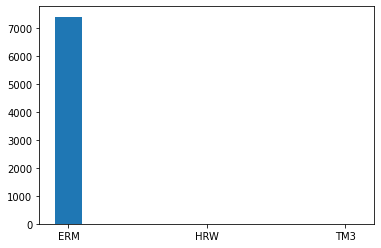

In [42]:
x = [k for k in tmp.keys()]
x.append("TM3")
y = [tmp[k] for k in tmp.keys()]
y.append(0)

plt.bar(x,y,width=0.2)
plt.title = "Most suspicious applcation"
plt.show()

From the graph, we can say that from cyber attacks standpoint it is meaningless giving much relevance to the weekday and the working time, as we have suspicious series regardless of the parameters related to these factors.

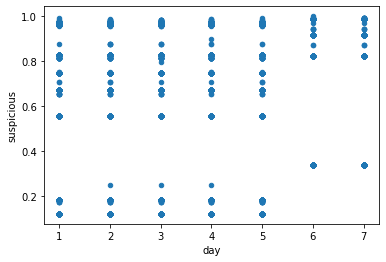

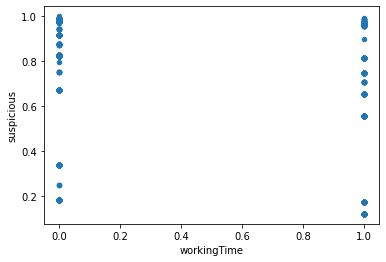

In [43]:
df_series.plot(x = 'day', y = 'suspicious', kind = 'scatter')
plt.show()
df_series.plot(x = 'workingTime', y = 'suspicious', kind = 'scatter')
plt.show()

Comparing the number of ip adresses and failed attempts we can notice that with a single ip the number of failed attempts is bigger.
_It may indicate the presence of a target of an attack_. 
**Possible scenario**: attackers know the username of an employee and so they try guessing the password. 

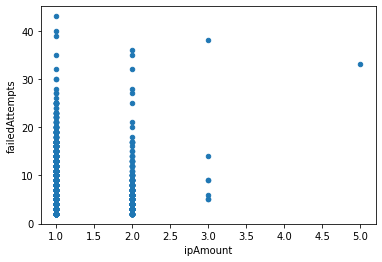

In [44]:
df_series.plot(x = 'ipAmount', y = 'failedAttempts', kind = 'scatter')
plt.show()

When the series of login attempts is closed with a successful attempt, the number of failed attempts is approximately half with respect to the complementary case.

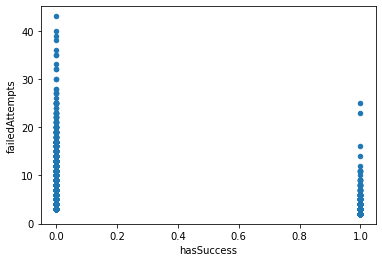

In [45]:
df_series.plot(x = 'hasSuccess', y = 'failedAttempts', kind = 'scatter')
plt.show()

The average time between login attempts and number of failures are approximately inversely proportional. Indeed _suspicious_ assumes values close to one when the average time narrows (the number of failed attempts increases).

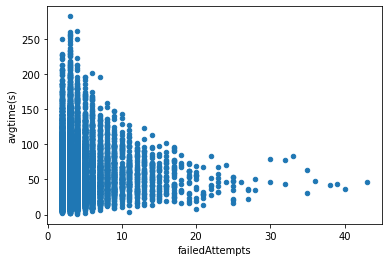

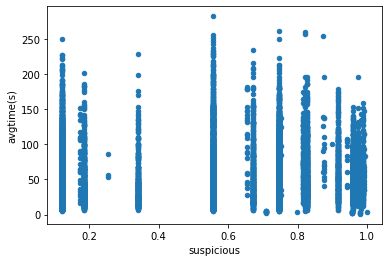

In [46]:
df_tmp = df_series.copy()
df_tmp["avgTime"] = df_tmp["avgTime"].apply(lambda x: int(x/1000))
df_tmp.plot(y="avgTime",x="failedAttempts",kind="scatter",ylabel="avgtime(s)")
df_tmp.plot(y="avgTime",x="suspicious",kind="scatter",ylabel="avgtime(s)")
plt.show()

<AxesSubplot:ylabel='userId'>

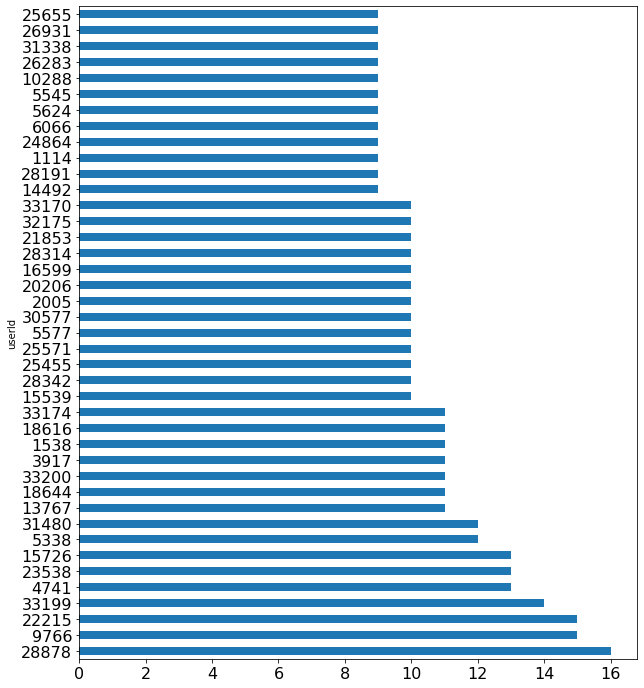

In [47]:
values = df_series['userId'].value_counts()
values = values[values > 8]
values.plot(kind='barh', figsize=(10,12), fontsize=16, ylabel="userId")

**userId 28878** is the user with the highest number of failed attempt series

In [48]:
df_series[df_series['userId'] == 28878]

,userId,avgTime,failedAttempts,hasSuccess,application,workingTime,day,ipAmount,suspicious
33203,28878,11000,2,1,ERM,1,2,1,0.122744
33210,28878,7000,3,1,ERM,1,3,1,0.122744
33212,28878,7333,3,1,ERM,1,5,1,0.122744
33214,28878,6000,3,1,ERM,1,4,1,0.122744
33219,28878,8500,2,1,ERM,1,3,1,0.122744
33221,28878,9000,2,1,ERM,1,3,1,0.122744
33224,28878,10000,2,1,ERM,1,4,1,0.122744
33235,28878,14500,2,1,ERM,1,5,1,0.122744
33236,28878,8000,3,1,ERM,1,5,1,0.122744
33238,28878,9000,2,1,ERM,1,5,1,0.122744


Although user 28878 has the largest number of series, all of them are due to incorrect password entry as they are all ended with a successful login, have a maximum length of three attempts, and a plausible average time for a human. Thus, relying on the number of series performed by a user can be misleading. Indeed, suspicious is low for each one.

## IP series analysis

In [49]:
# store errors login series for ip
failedAttemptsSeriesIP = dict()
# sort dataframe
df_logins.sort_values(by=["ip","date"],ascending=(True, True),inplace=True)
df_groupBy_ip = df_logins.groupby(by=["ip"])
# get keys
ips = np.unique(df_logins["ip"])
# find series for ip
findSeries(subjects=ips,df_groupBySubject=df_groupBy_ip,storage=failedAttemptsSeriesIP,userMode=False)

In [50]:
# computing metics
seriesEvalIndex = computeMetrics(failedAttemptsSeriesIP)
df_ip_series = pd.DataFrame(seriesEvalIndex,columns=["ip","avgTime","failedAttempts","hasSuccess","application","workingTime","day","userAmount"])
# delete series with just one login erroe, thus average time equal to 0
df_ip_series.drop(df_ip_series[ df_ip_series["avgTime"] == 0 ].index,inplace=True)
# compute suspicious heuristic for each series
df_ip_series['suspicious'] = df_ip_series.apply(lambda row : suspicious(row), axis=1)
df_ip_series.describe()

,avgTime,failedAttempts,hasSuccess,workingTime,day,userAmount,suspicious
count,13376.000000,13376.000000,13376.000000,13376.000000,13376.000000,13376.000000,13376.000000
mean,51383.542688,3.826256,0.520634,0.807715,3.156848,1.076779,0.475255
std,39058.243315,2.851309,0.499593,0.394110,1.698882,0.389790,0.320932
min,1000.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.122744
25%,22000.000000,2.000000,0.000000,1.000000,2.000000,1.000000,0.122744
50%,39500.000000,3.000000,1.000000,1.000000,3.000000,1.000000,0.557377
75%,70073.750000,4.000000,1.000000,1.000000,5.000000,1.000000,0.746082
max,286500.000000,43.000000,1.000000,1.000000,7.000000,12.000000,0.999348


In [51]:
# visualize most suspicious series
df_ip_series[df_ip_series["suspicious"] == df_ip_series["suspicious"].max()]

,ip,avgTime,failedAttempts,hasSuccess,application,workingTime,day,userAmount,suspicious
27027,ip_38662,4000,11,0,ERM,0,6,1,0.999348
34469,ip_5989,4142,8,0,ERM,0,6,1,0.999348


### Plotting amount weigths

#### Plotting weigth releated to ip used within a series

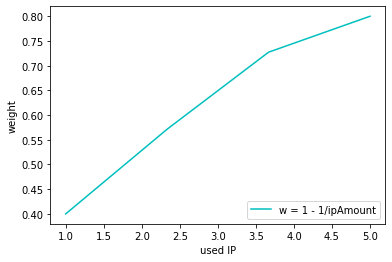

In [52]:
max_ip_amount = df_series["ipAmount"].max()
min_ip_amount = df_series["ipAmount"].min()
samples = max_ip_amount - min_ip_amount
x = np.linspace(start=min_ip_amount,stop=max_ip_amount,num=samples,endpoint=True)
y = []
for amount in x:
    y.append(1 - (1/amount if amount > 1 else 0.6))


plt.plot(x,y,'c',label="w = 1 - 1/ipAmount")
plt.xlabel("used IP")
plt.ylabel("weight")
plt.legend(loc='lower right')
plt.show()

#### Plotting weigth releated to the target users within a series

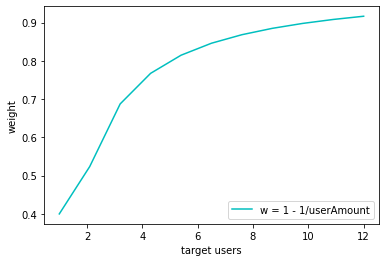

In [53]:
max_ip_amount = df_ip_series["userAmount"].max()
min_ip_amount = df_ip_series["userAmount"].min()
samples = max_ip_amount - min_ip_amount
x = np.linspace(start=min_ip_amount,stop=max_ip_amount,num=samples,endpoint=True)
y = []
for amount in x:
    y.append(1 - (1/amount if amount > 1 else 0.6))


plt.plot(x,y,'c',label="w = 1 - 1/userAmount")
plt.xlabel("target users")
plt.ylabel("weight")
plt.legend(loc='lower right')
plt.show()

**Observation**: The number of users within a series has a higher weigth than the number of used IP addresses on the *suspiciousness* of the series. Therefore, to detect an attack considering the failed attempts series tracking the IP address may be more meaningful.

### Plotting

When requests coming from the same IP are for different users, the average time between attempts decreases. 
Therefore, an attack is going on because the requests are being performed rapidly.

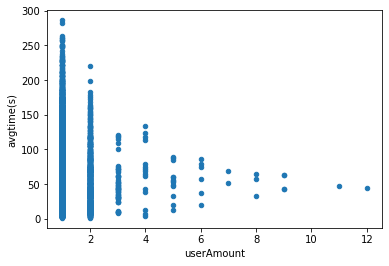

In [54]:
df_cp = df_ip_series.copy()
df_cp["avgTime"] = df_ip_series["avgTime"].apply(lambda x: int(x/1000))

df_cp.plot(x = 'userAmount', y = 'avgTime', kind = 'scatter',ylabel="avgtime(s)")
plt.show()

Looking at the number of failed attempts and the number of users, it can be observed that no correlation is present.

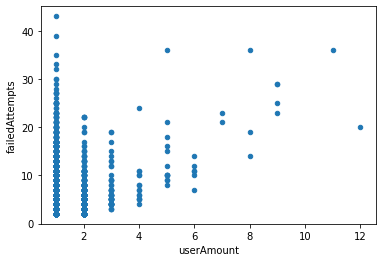

In [55]:
df_ip_series.plot(x = 'userAmount', y = 'failedAttempts', kind = 'scatter')
plt.show()

<AxesSubplot:ylabel='ip'>

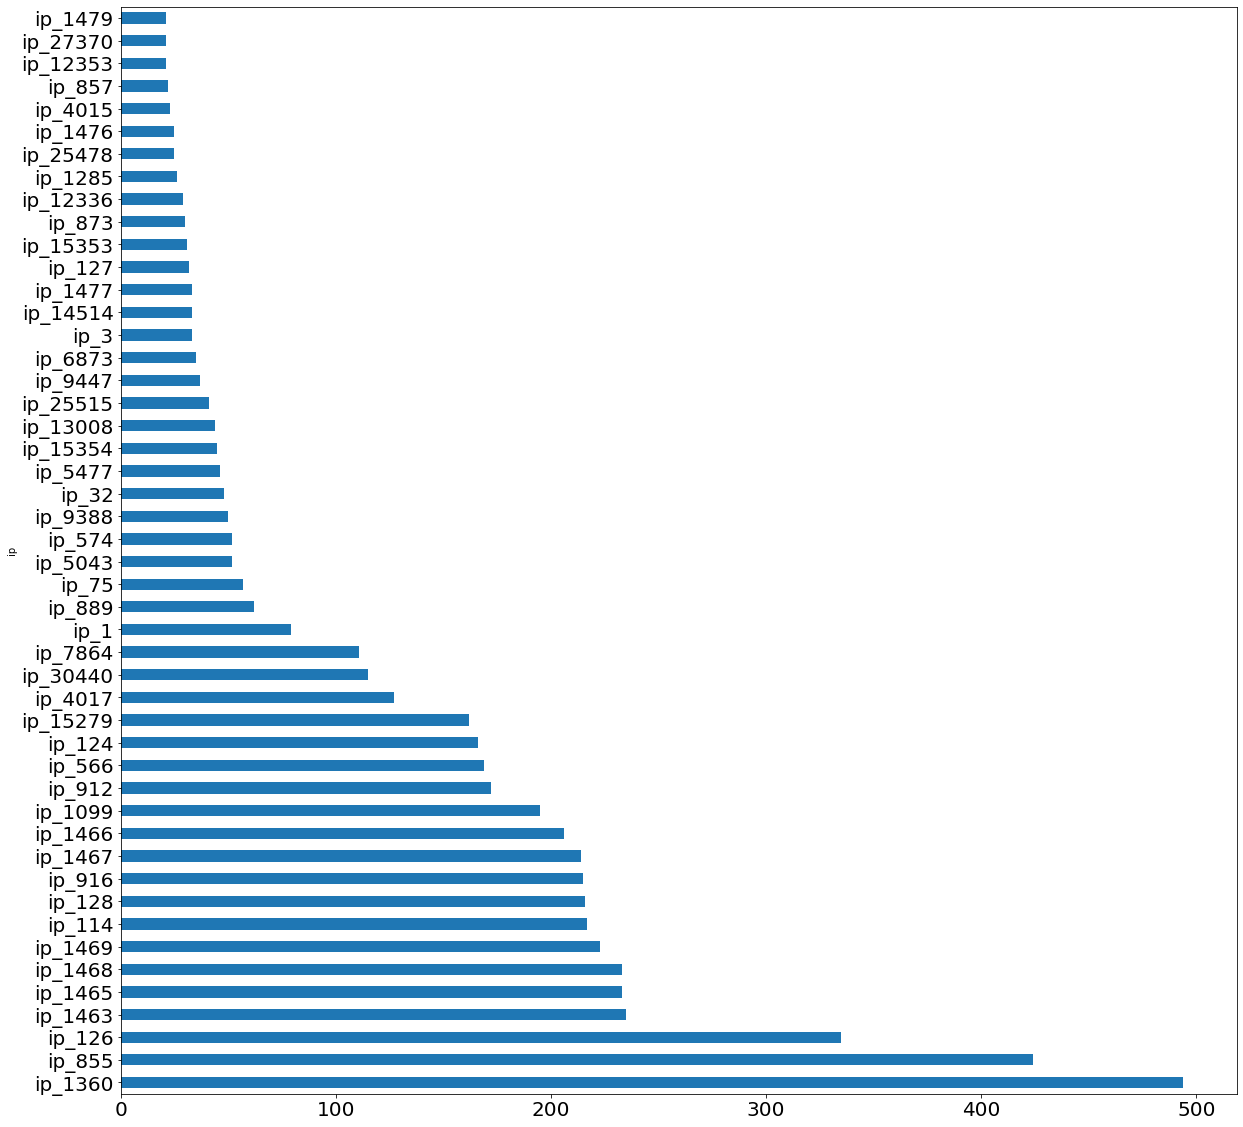

In [56]:
values = df_ip_series['ip'].value_counts()
values = values[values > 20]
values.plot(kind='barh', figsize=(20,20), fontsize=20,  ylabel="ip")

**ip_1360** is the IP with the highest number of failed attempt series

In [57]:
df_ip_series[df_ip_series['ip'] == 'ip_1360']['suspicious'].describe()

count    494.000000
mean       0.458877
std        0.335637
min        0.122744
25%        0.122744
50%        0.557377
75%        0.746082
max        0.996529
Name: suspicious, dtype: float64

Here the ip_1360 has the highest number of series and, accordingly to that, there are series with suspicious value up to (approximately) 0.997. Intuitively, looking at the most frequent incoming IP address may provide some knowledge about possible attacks.